# DACON 신용카드 사용자 데이터

# I. 배경
#### -	현재 금융업계는 AI 활용 금융 서비스 구현을 목표로 삼고 있음 
#### -	카드사는 신용카드 신청자가 제출한 개인정보와 데이터를 활용해 신용점수 산정
#### - 	신용점수를 활용해 신청자의 향후 채무불이행과 신용카드 대급 연체 가능성을 예측

#### https://mciexperian.com/
#### ----------------------------------------------------------------------------------------------------------------------

# II. 목적
#### -	신용카드 사용자의 개인정보 데이터로 사용자의 대금 연체 정도(신용도)를 예측하는 알고리즘 개발 
#### ----------------------------------------------------------------------------------------------------------------------

# III. 대상 및 범위
### 1)	대상
#### 2019년도 중국의 “숑쉐탕”이라는 교육플랫폼의  데이터 모델링 커리큘럼에서 사용한 신용카드 신청자 인적사항 등의 데이터 예시

### 2)	범위
#### -	해당 데이터의 csv파일, Dacon에 공유된 설명 및 코드
#### -	약  2만 6천명 고객의 19가지 사항에 대한 데이터 (신용도 + 18개 기타 정보)
#### ----------------------------------------------------------------------------------------------------------------------

# IV.연구 방법
## 1. EDA
#### - 간략한 시각화를 통해 FEATURES 선정
#### ----------------------------------------------------------------------------------------------------------------------
## 2. 전처리
#### - 총 4가지 훈련 데이터 변수 저장 
#### 1) df_label, 2) df_uniq_label, 3) df_oh, 4) df_uniq_oh
#### ----------------------------------------------------------------------------------------------------------------------
## 3. 모델링 & 자체검증
#### - 총 9가지 모델 검증 및 앙상블 모델 활용
#### ----------------------------------------------------------------------------------------------------------------------
## 4. 최종 모델 결정
#### - 해당 모델을 활용해 학습 및 예측
#### ----------------------------------------------------------------------------------------------------------------------

# V. 코드
# 1. EDA

In [1]:
# 기본 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 가져오기
df = pd.read_csv('./train.csv')
df2 = pd.read_csv('./test.csv')

<AxesSubplot:>

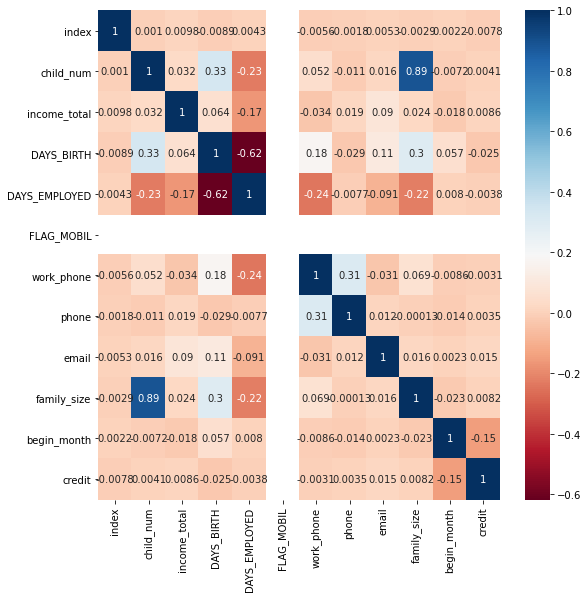

In [2]:
# 데이터의 상관관계 살펴보기
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(9,9))
corr = df.corr()
sns.heatmap(corr,cmap='RdBu', annot=True)

# 2. 전처리
## 2.1 공동 전처리
### (1) 훈련 데이터 train -> df

In [3]:
# 1.NULL값 처리 및 이진 분류
# NULL -> 'N'
df['occyp_type'].fillna('N', inplace=True)

# 무직 or 직장 분류
temp = []
for i in df['occyp_type']:
    if i == 'N':
        i = 0
    else:
        i = 1
    temp.append(i)

df['occyp_type'] = pd.Series(temp)

# 2.제외할 features 드롭
for i in ['child_num','FLAG_MOBIL','phone','work_phone', 'email']:
    df = df.drop([i], axis=1)

# 3.일수, 월수 데이터 -- 음수 -> 양수
df['DAYS_BIRTH'] = df['DAYS_BIRTH'] * (-1)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] * (-1)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(-365243, 99999)
df['begin_month'] = df['begin_month'] * (-1)

# 4.성별, 여부 -- 이진분류
df['gender'] = df['gender'].replace('M',0)
df['gender'] = df['gender'].replace('F',1)
df['car'] = df['car'].replace('N',0)
df['car'] = df['car'].replace('Y',1)
df['reality'] = df['reality'].replace('N',0)
df['reality'] = df['reality'].replace('Y',1)

# 5.edu_type 학력 순서대로 맵핑 인코딩
edu_order = {'Lower secondary' : 0, # 중학교 미만
             'Secondary / secondary special' : 1, #중학교
             'Incomplete higher' : 2, # 고등학교 중퇴
             'Higher education' : 3, # 고등학교 졸업
             'Academic degree' : 4} # 학사 이상
df.edu_type = df.edu_type.map(edu_order)
'''
# # 6.1 중복값 표현 
# df['identity'] = [str(i) + str(c) + str(j) + str(k) + str(l) + str(m) + str(n) + str(o) for i,c,j,k,l,m,n,o in zip(df['gender'],df['car'],df['reality'], df['edu_type'], df['income_total'], df['income_type'], df['DAYS_BIRTH'], df['DAYS_EMPLOYED'])]

# print(f"df set 중복데이터가 아닌 사람의 수 : {sum(df['identity'].value_counts()==1)}명")

# print('-'*60)
# print(f"df set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(df['identity'].value_counts()>=2)}명")

# display(df['identity'].value_counts())
# df = df.drop('identity', axis=1)
'''
# 6.2 중복값 제거 (option: 주석 = 26457, 실행 = 8737)
df_uniq = df.drop_duplicates(['gender', 'car', 'reality','edu_type','income_total','income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED'], keep="last", ignore_index = True)

# 6.3 인덱스 제거
df_uniq = df_uniq.drop('index', axis=1)
df = df.drop('index', axis=1)
df.shape, df_uniq.shape

((26457, 14), (8737, 14))

### (2) 테스트 데이터 test -> df2

In [4]:
# 1.NULL값 처리 및 이진 분류
# NULL -> 'N'
df2['occyp_type'].fillna('N', inplace=True)

# 무직 or 직장 분류
temp = []
for i in df2['occyp_type']:
    if i == 'N':
        i = 0
    else:
        i = 1
    temp.append(i)

df2['occyp_type'] = pd.Series(temp)

# 2.제외할 features 드롭
for i in ['child_num','FLAG_MOBIL','phone','work_phone', 'email']:
    df2 = df2.drop([i], axis=1)

# 3.일수, 월수 데이터 -- 음수 -> 양수
df2['DAYS_BIRTH'] = df2['DAYS_BIRTH'] * (-1)
df2['DAYS_EMPLOYED'] = df2['DAYS_EMPLOYED'] * (-1)
df2['DAYS_EMPLOYED'] = df2['DAYS_EMPLOYED'].replace(-365243, 99999)
df2['begin_month'] = df2['begin_month'] * (-1)

# 4.성별, 여부 -- 이진분류
df2['gender'] = df2['gender'].replace('M',0)
df2['gender'] = df2['gender'].replace('F',1)
df2['car'] = df2['car'].replace('N',0)
df2['car'] = df2['car'].replace('Y',1)
df2['reality'] = df2['reality'].replace('N',0)
df2['reality'] = df2['reality'].replace('Y',1)

# 5.edu_type 학력 순서대로 맵핑 인코딩
edu_order = {'Lower secondary' : 0, # 중학교 미만
             'Secondary / secondary special' : 1, #중학교
             'Incomplete higher' : 2, # 고등학교 중퇴
             'Higher education' : 3, # 고등학교 졸업
             'Academic degree' : 4} # 학사 이상
df2.edu_type = df2.edu_type.map(edu_order)

# 6 인덱스 제거
df2 = df2.drop('index', axis=1)
df2.shape

(10000, 13)

## 2.2 중복 포함 데이터 전처리 (df, df2)

In [5]:
# 이후 전처리 형태 만들기전에 df 복사해주기
df_label = df
df_oh = df
df_uniq_label = df_uniq
df_uniq_oh = df_uniq

df2_label = df2
df2_oh = df2

### 2.2.1 Label Encoding (df, df2)

### (1) 훈련 데이터 df -> df_label

In [6]:
## df_label 전처리
from sklearn.preprocessing import LabelEncoder

# income_type label encoder 
encoder = LabelEncoder()
encoder.fit(df_label['income_type'])
feature = encoder.transform(df_label['income_type'])
print('income_type의 인코딩 변환값 : ', feature)
feature = pd.Series(feature)
df_label['income_type'] = feature

# family_type label encoder
encoder = LabelEncoder()
encoder.fit(df_label['family_type'])
feature_family = encoder.transform(df_label['family_type'])
print('family_type의 인코딩 변환값 : ', feature_family)
feature_family = pd.Series(feature_family)
df_label['family_type'] = feature

# house_type label encoder 
encoder = LabelEncoder()
encoder.fit(df_label['house_type'])
feature = encoder.transform(df_label['house_type'])
print('house_type의 인코딩 변환값 : ', feature)
feature = pd.Series(feature)
df_label['house_type'] = feature

# family_size label encoder 
encoder = LabelEncoder()
encoder.fit(df_label['family_size'])
feature = encoder.transform(df_label['family_size'])
print('family_size의 인코딩 변환값 : ', feature)
feature = pd.Series(feature)
df_label['family_size'] = feature

#-----------------------------------------------------------------------#
#이상치 제거
quartile_1 = df_label['income_total'].quantile(0.25)
quartile_3 = df_label['income_total'].quantile(0.75)
IQR = quartile_3 - quartile_1
search_df = df_label[(df_label['income_total'] < (quartile_1 - 1.5 * IQR)) | (df_label['income_total'] > (quartile_3 + 1.5 * IQR))]
df_label = df_label.drop(search_df.index, axis=0)   

#-----------------------------------------------------------------------#
## 구간 레이블링
# import numpy as np
# def make_bin(array, n):
#     _, bin_dividers = np.histogram(array, bins = n)
#     cut_categories = pd.cut(array, bin_dividers, labels = [i for i in range(n)],
#          include_lowest=True )
#     bined_array = pd.factorize(cut_categories)[0]
    
#     return bined_array

# display(df_label['DAYS_EMPLOYED'].value_counts())

## 구간 레이블링 컬럼 선택
# df_label['income_total'] = make_bin(df_label['income_total'], 7)  # 3보다 큰 레이블 그냥 3에 다 집어 넣자
# df_label['DAYS_BIRTH'] = make_bin(df_label['DAYS_BIRTH'], 7)
# df_label['DAYS_EMPLOYED'] = make_bin(df_label['DAYS_EMPLOYED'], 7)
# df_label['begin_month'] = make_bin(df_label['begin_month'], 7)

#-----------------------------------------------------------------------#
# DAYS_EMPLOYED 정규화
from sklearn.preprocessing import MinMaxScaler

df_label_normal = df_label

scaler = MinMaxScaler()
numpy_em = df_label_normal['DAYS_EMPLOYED'].to_numpy().reshape(-1,1)
feature_num_em = scaler.fit(numpy_em)
num_em_scaled = scaler.transform(numpy_em)
list_em = list(numpy_em.reshape(-1,))
list_scaled = list(num_em_scaled.reshape(-1,))
type(list_em[1])
dict_num_em = {}

for i in range(len(list_em)):
    dict_num_em[list_em[i]] = list_scaled[i]
df_label_normal['DAYS_EMPLOYED'] = df_label_normal['DAYS_EMPLOYED'].map(dict_num_em, na_action=None)

df_label_normal.shape

income_type의 인코딩 변환값 :  [0 0 4 ... 4 4 4]
family_type의 인코딩 변환값 :  [1 0 1 ... 0 3 0]
house_type의 인코딩 변환값 :  [2 1 1 ... 5 1 1]
family_size의 인코딩 변환값 :  [1 2 1 ... 1 0 1]


(25328, 14)

### (2) 테스트 데이터 df2 -> df2_label

In [7]:
## df2_label 전처리
from sklearn.preprocessing import LabelEncoder

# income_type label encoder 
encoder = LabelEncoder()
encoder.fit(df2_label['income_type'])
feature = encoder.transform(df2_label['income_type'])
print('income_type의 인코딩 변환값 : ', feature)
feature = pd.Series(feature)
df2_label['income_type'] = feature

# family_type label encoder
encoder = LabelEncoder()
encoder.fit(df2_label['family_type'])
feature_family = encoder.transform(df2_label['family_type'])
print('family_type의 인코딩 변환값 : ', feature_family)
feature_family = pd.Series(feature_family)
df2_label['family_type'] = feature

# house_type label encoder 
encoder = LabelEncoder()
encoder.fit(df2_label['house_type'])
feature = encoder.transform(df2_label['house_type'])
print('house_type의 인코딩 변환값 : ', feature)
feature = pd.Series(feature)
df2_label['house_type'] = feature

# family_size label encoder 
encoder = LabelEncoder()
encoder.fit(df2_label['family_size'])
feature = encoder.transform(df2_label['family_size'])
print('family_size의 인코딩 변환값 : ', feature)
feature = pd.Series(feature)
df2_label['family_size'] = feature

#-----------------------------------------------------------------------#
## 구간 레이블링
# import numpy as np
# def make_bin(array, n):
#     _, bin_dividers = np.histogram(array, bins = n)
#     cut_categories = pd.cut(array, bin_dividers, labels = [i for i in range(n)],
#          include_lowest=True )
#     bined_array = pd.factorize(cut_categories)[0]
    
#     return bined_array

# display(df2_label['DAYS_EMPLOYED'].value_counts())

## 구간 레이블링 컬럼 선택
# df2_label['income_total'] = make_bin(df2_label['income_total'], 7)  # 3보다 큰 레이블 그냥 3에 다 집어 넣자
# df2_label['DAYS_BIRTH'] = make_bin(df2_label['DAYS_BIRTH'], 7)
# df2_label['DAYS_EMPLOYED'] = make_bin(df2_label['DAYS_EMPLOYED'], 7)
# df2_label['begin_month'] = make_bin(df2_label['begin_month'], 7)


#-----------------------------------------------------------------------#
# DAYS_EMPLOYED 정규화
from sklearn.preprocessing import MinMaxScaler

df2_label_normal = df2_label

scaler = MinMaxScaler()
numpy_em = df2_label_normal['DAYS_EMPLOYED'].to_numpy().reshape(-1,1)
feature_num_em = scaler.fit(numpy_em)
num_em_scaled = scaler.transform(numpy_em)
list_em = list(numpy_em.reshape(-1,))
list_scaled = list(num_em_scaled.reshape(-1,))
type(list_em[1])
dict_num_em = {}

for i in range(len(list_em)):
    dict_num_em[list_em[i]] = list_scaled[i]
df2_label_normal['DAYS_EMPLOYED'] = df2_label_normal['DAYS_EMPLOYED'].map(dict_num_em, na_action=None)

df2_label.head()
df2_label.shape

income_type의 인코딩 변환값 :  [1 2 4 ... 4 0 4]
family_type의 인코딩 변환값 :  [0 1 1 ... 1 1 1]
house_type의 인코딩 변환값 :  [1 1 1 ... 1 1 1]
family_size의 인코딩 변환값 :  [1 1 1 ... 1 1 1]


(10000, 13)

### 2.2.2 One-hot Encoding

### (1) 훈련 데이터 df -> df_oh

In [8]:
## df_oh 전처리
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# income_type one-hot encoder 
target_col = ['income_type']
encoder.fit(df_oh.loc[:,target_col])
df_i = pd.DataFrame(encoder.transform(df_oh[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df_oh = pd.concat([df_oh,df_i], axis = 1)

# family_type one-hot encoder 
target_col = ['family_type']
encoder.fit(df_oh.loc[:,target_col])
df_f = pd.DataFrame(encoder.transform(df_oh[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df_oh = pd.concat([df_oh, df_f], axis = 1)

# house_type one-hot encoder 
target_col = ['house_type']
encoder.fit(df_oh.loc[:,target_col])
df_h = pd.DataFrame(encoder.transform(df_oh[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df_oh = pd.concat([df_oh, df_h], axis = 1)

# 기존 컬럼 삭제
for i in ['income_type','family_type','house_type']:
    df_oh = df_oh.drop([i], axis=1)

#-----------------------------------------------------------------------#
#이상치 제거
quartile_1 = df_oh['income_total'].quantile(0.25)
quartile_3 = df_oh['income_total'].quantile(0.75)
IQR = quartile_3 - quartile_1
search_df = df_oh[(df_oh['income_total'] < (quartile_1 - 1.5 * IQR)) | (df_oh['income_total'] > (quartile_3 + 1.5 * IQR))]
df_oh = df_oh.drop(search_df.index, axis=0)

#-----------------------------------------------------------------------#
# DAYS_EMPLOYED 정규화
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_oh_normal = df_oh

scaler = MinMaxScaler()
numpy_em = df_oh_normal['DAYS_EMPLOYED'].to_numpy().reshape(-1,1)
feature_num_em = scaler.fit(numpy_em)
num_em_scaled = scaler.transform(numpy_em)
list_em = list(numpy_em.reshape(-1,))
list_scaled = list(num_em_scaled.reshape(-1,))
type(list_em[1])

dict_num_em = {}

for i in range(len(list_em)):
    dict_num_em[list_em[i]] = list_scaled[i]
df_oh_normal['DAYS_EMPLOYED'] = df_oh_normal['DAYS_EMPLOYED'].map(dict_num_em, na_action=None)
df_oh_normal.shape

(25328, 27)

### (2) 테스트 데이터 df2 -> df2_oh

In [9]:
## df2_oh 전처리
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# income_type one-hot encoder 
target_col = ['income_type']
encoder.fit(df2.loc[:,target_col])
df2_i = pd.DataFrame(encoder.transform(df2[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df2_oh = pd.concat([df2_oh,df2_i], axis = 1)

# family_type one-hot encoder 
target_col = ['family_type']
encoder.fit(df2.loc[:,target_col])
df2_f = pd.DataFrame(encoder.transform(df2[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df2_oh = pd.concat([df2_oh, df2_f], axis = 1)

# house_type one-hot encoder 
target_col = ['house_type']
encoder.fit(df2.loc[:,target_col])
df2_h = pd.DataFrame(encoder.transform(df2[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df2_oh = pd.concat([df2_oh, df2_h], axis = 1)

# 기존 컬럼 삭제
for i in ['income_type','family_type','house_type']:
    df2_oh = df2_oh.drop([i], axis=1)
    
#-----------------------------------------------------------------------#
# DAYS_EMPLOYED 정규화
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df2_oh_normal = df2_oh

scaler = MinMaxScaler()
numpy_em = df2_oh_normal['DAYS_EMPLOYED'].to_numpy().reshape(-1,1)
feature_num_em = scaler.fit(numpy_em)
num_em_scaled = scaler.transform(numpy_em)
list_em = list(numpy_em.reshape(-1,))
list_scaled = list(num_em_scaled.reshape(-1,))
type(list_em[1])

dict_num_em = {}

for i in range(len(list_em)):
    dict_num_em[list_em[i]] = list_scaled[i]
df2_oh_normal['DAYS_EMPLOYED'] = df2_oh_normal['DAYS_EMPLOYED'].map(dict_num_em, na_action=None)
df2_oh_normal

,gender,car,reality,income_total,edu_type,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,family_size,begin_month,...,family_type_1,family_type_2,family_type_3,family_type_4,house_type_0,house_type_1,house_type_2,house_type_3,house_type_4,house_type_5
0,0,1,0,112500.0,1,21990,1.000000,0,1,60.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,1,135000.0,3,18964,0.086556,1,1,36.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,0,1,69372.0,1,15887,0.002000,1,1,40.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,1,0,112500.0,1,19270,0.025145,1,1,41.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1,1,225000.0,3,17822,0.093697,1,1,8.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,1,202500.0,2,18593,0.054180,1,1,19.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9996,0,1,1,202500.0,1,10886,0.012982,1,1,34.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,1,0,1,292500.0,1,21016,0.140035,1,1,55.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,1,1,0,180000.0,1,16541,0.010682,0,1,33.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# 2.3 중복 제거 데이터 전처리

### 2.3.1 훈련 데이터 df_uniq -> df_uniq_label

In [10]:
## df_uniq_label 전처리
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# income_type label encoder
encoder.fit(df_uniq_label['income_type'])
feature = encoder.transform(df_uniq_label['income_type'])
print('income_type의 인코딩 변환값 : ', feature)
feature = np.array(feature)
df_uniq_label['income_type'] = feature

# family_type label encoder 
encoder.fit(df_uniq_label['family_type'])
feature = encoder.transform(df_uniq_label['family_type'])
print('family_type의 인코딩 변환값 : ', feature)
feature = np.array(feature)
df_uniq_label['family_type'] = feature

# house_type label encoder 
encoder.fit(df_uniq_label['house_type'])
feature = encoder.transform(df_uniq_label['house_type'])
print('house_type의 인코딩 변환값 : ', feature)
feature = np.array(feature)
df_uniq_label['house_type'] = feature

# family_size label encoder 
encoder.fit(df_uniq_label['family_size'])
feature = encoder.transform(df_uniq_label['family_size'])
print('family_size의 인코딩 변환값 : ', feature)
feature = np.array(feature)
df_uniq_label['family_size'] = feature

#-----------------------------------------------------------------------#
# # 구간 레이블링
# def make_bin(array, n):
#     _, bin_dividers = np.histogram(array, bins = n)
#     cut_categories = pd.cut(array, bin_dividers, labels = [i for i in range(n)],
#          include_lowest=True )
#     bined_array = pd.factorize(cut_categories)[0]
    
#     return bined_array

# # 구간 레이블링 컬럼 선택
# df_uniq_label['income_total'] = make_bin(df_uniq_label['income_total'], 7)  # 3보다 큰 레이블 그냥 3에 다 집어 넣자
# df_uniq_label['DAYS_BIRTH'] = make_bin(df_uniq_label['DAYS_BIRTH'], 7)
# df_uniq_label['DAYS_EMPLOYED'] = make_bin(df_uniq_label['DAYS_EMPLOYED'], 7)
# df_uniq_label['begin_month'] = make_bin(df_uniq_label['begin_month'], 7)

#-----------------------------------------------------------------------#
#이상치 제거
quartile_1 = df_uniq_label['income_total'].quantile(0.25)
quartile_3 = df_uniq_label['income_total'].quantile(0.75)
IQR = quartile_3 - quartile_1
search_df = df_uniq_label[(df_uniq_label['income_total'] < (quartile_1 - 1.5 * IQR)) | (df_uniq_label['income_total'] > (quartile_3 + 1.5 * IQR))]
df_uniq_label = df_uniq_label.drop(search_df.index, axis=0)   

#-----------------------------------------------------------------------#
# DAYS_EMPLOYED 정규화
from sklearn.preprocessing import MinMaxScaler

df_uniq_label_normal = df_uniq_label

scaler = MinMaxScaler()
numpy_em = df_uniq_label_normal['DAYS_EMPLOYED'].to_numpy().reshape(-1,1)
feature_num_em = scaler.fit(numpy_em)
num_em_scaled = scaler.transform(numpy_em)
list_em = list(numpy_em.reshape(-1,))
list_scaled = list(num_em_scaled.reshape(-1,))
type(list_em[1])
dict_num_em = {}

for i in range(len(list_em)):
    dict_num_em[list_em[i]] = list_scaled[i]
df_uniq_label_normal['DAYS_EMPLOYED'] = df_uniq_label_normal['DAYS_EMPLOYED'].map(dict_num_em, na_action=None)

df_uniq_label_normal.shape

income_type의 인코딩 변환값 :  [2 4 4 ... 4 4 4]
family_type의 인코딩 변환값 :  [1 1 1 ... 0 3 0]
house_type의 인코딩 변환값 :  [1 1 1 ... 5 1 1]
family_size의 인코딩 변환값 :  [1 3 1 ... 1 0 1]


(8440, 14)

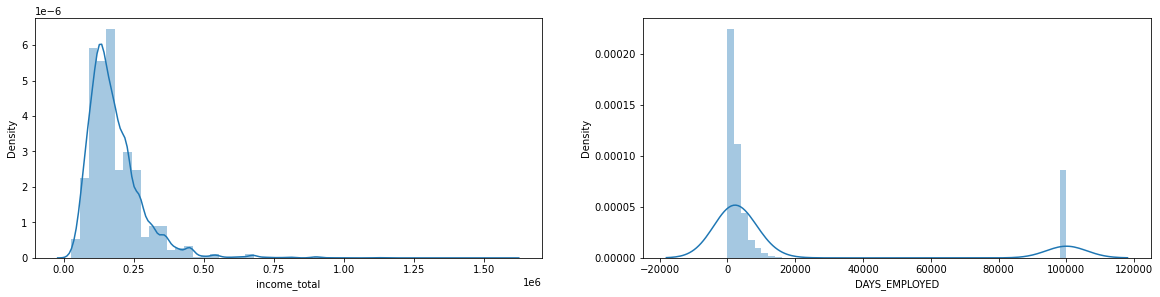

In [11]:
# 이상치 제거, 정규화 전
columns = ['income_total','DAYS_EMPLOYED']
plt.figure(figsize = (20,15))
for i in range(2):
    plt.subplot(3,2,i+1)
    sns.distplot(df_uniq[columns[i]])
plt.show()

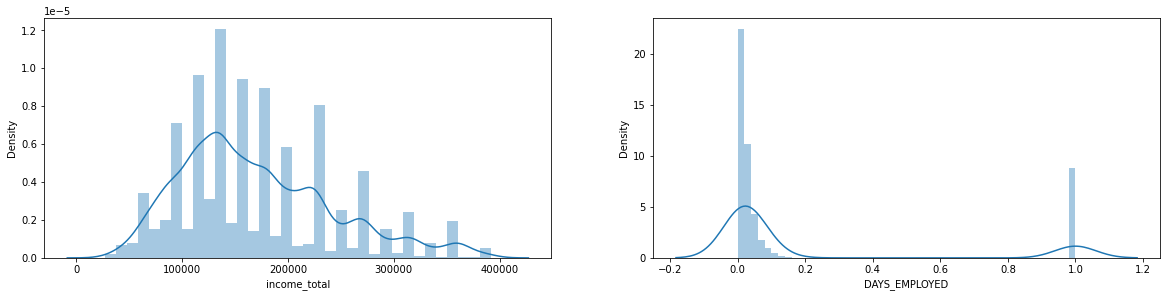

In [12]:
# 이상치 제거, 정규화 후
plt.figure(figsize = (20,15))
for i in range(2):
    plt.subplot(3,2,i+1)
    sns.distplot(df_uniq_label[columns[i]])
plt.show()

### 1.3.2 훈련 데이터 df_uniq -> df_uniq_oh

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# income_type one-hot encoder 
target_col = ['income_type']
encoder.fit(df_uniq.loc[:,target_col])
df_i = pd.DataFrame(encoder.transform(df_uniq[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df_uniq_oh = pd.concat([df_uniq_oh,df_i], axis = 1)

# family_type one-hot encoder 
target_col = ['family_type']
encoder.fit(df_uniq.loc[:,target_col])
df_f = pd.DataFrame(encoder.transform(df_uniq[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df_uniq_oh = pd.concat([df_uniq_oh, df_f], axis = 1)

# house_type one-hot encoder 
target_col = ['house_type']
encoder.fit(df_uniq.loc[:,target_col])
df_h = pd.DataFrame(encoder.transform(df_uniq[target_col]).toarray(), 
             columns=encoder.get_feature_names(target_col))
df_uniq_oh = pd.concat([df_uniq_oh, df_h], axis = 1)

# 기존 컬럼 삭제
for i in ['income_type','family_type','house_type']:
    df_uniq_oh = df_uniq_oh.drop([i], axis=1)

#-----------------------------------------------------------------------#
#이상치 제거
quartile_1 = df_uniq_oh['income_total'].quantile(0.25)
quartile_3 = df_uniq_oh['income_total'].quantile(0.75)
IQR = quartile_3 - quartile_1
search_df = df_uniq_oh[(df_uniq_oh['income_total'] < (quartile_1 - 1.5 * IQR)) | (df_uniq_oh['income_total'] > (quartile_3 + 1.5 * IQR))]
df_uniq_oh = df_uniq_oh.drop(search_df.index, axis=0)   
    
#-----------------------------------------------------------------------#
# DAYS_EMPLOYED 정규화
df_uniq_oh_normal = df_uniq_oh

from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
numpy_em = df_uniq_oh_normal['DAYS_EMPLOYED'].to_numpy().reshape(-1,1)
feature_num_em = scaler.fit(numpy_em)
num_em_scaled = scaler.transform(numpy_em)
list_em = list(numpy_em.reshape(-1,))
list_scaled = list(num_em_scaled.reshape(-1,))
type(list_em[1])
dict_num_em = {}

for i in range(len(list_em)):
    dict_num_em[list_em[i]] = list_scaled[i]
df_uniq_oh_normal['DAYS_EMPLOYED'] = df_uniq_oh_normal['DAYS_EMPLOYED'].map(dict_num_em, na_action=None)

df_uniq_oh_normal.shape

(8440, 27)

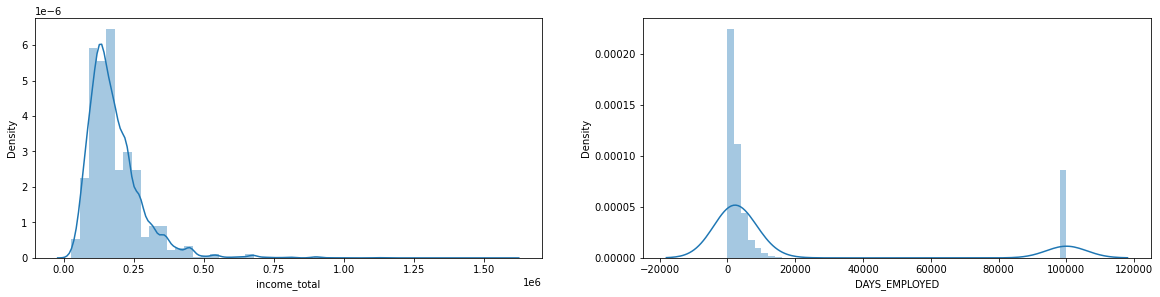

In [14]:
# 이상치 제거, 정규화 전
plt.figure(figsize = (20,15))
for i in range(2):
    plt.subplot(3,2,i+1)
    sns.distplot(df_uniq[columns[i]])
plt.show()

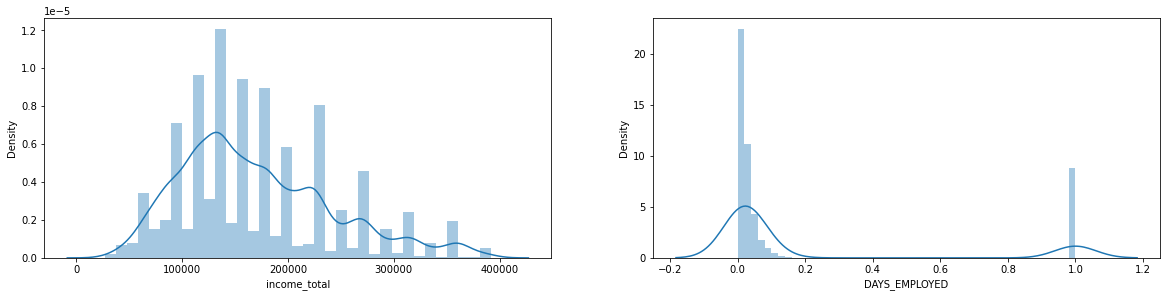

In [15]:
# 이상치 제거, 정규화 후
plt.figure(figsize = (20,15))
for i in range(2):
    plt.subplot(3,2,i+1)
    sns.distplot(df_uniq_oh[columns[i]])
plt.show()

# 3. 모델링 & 자체검증

## 3.1 Module Import & Function

In [17]:
# Importing packages for modelling.
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer

m_logreg = LogisticRegression()
m_gbc = GradientBoostingClassifier()
m_rfc = RandomForestClassifier(criterion='gini', n_estimators=1800, max_depth=4, random_state=14)
m_lgb = lgb.LGBMClassifier(num_iterations=550, learning_rate=0.01055, max_depth=2, random_state=14)
m_xgb = xgb.XGBClassifier(n_estimators=2250, max_depth=2, random_state=14, eval_metric='mlogloss')
m_gnb = GaussianNB()
m_mlpc = MLPClassifier(random_state=14)
m_svc = SVC(probability=True)
m_knn = KNeighborsClassifier(n_neighbors=6)

vo_clf = VotingClassifier(estimators=[('LR', m_logreg), ('KNN', m_knn), ('XGB', m_xgb)], voting='soft')

def estimates(X_data, y_data, models, cv):
    
    train_acc_dict = dict()
    test_acc_dict = dict()
    time_dict = dict()
    
    for model in models:
        
        current_model_name = model.__class__.__name__
        
        cv_results = cross_validate(model, X_data, y_data, cv=cv,
                                    return_train_score=True, scoring='neg_log_loss')
        
        train_acc_dict[current_model_name] = cv_results['train_score'].mean()
        test_acc_dict[current_model_name] = cv_results['test_score'].mean()
        time_dict[current_model_name] = cv_results['fit_time'].mean()
        print(cv_results['train_score'])
        print(cv_results['test_score'])
        
    return train_acc_dict, test_acc_dict, time_dict

## 3.2 Validation

### 3.2.1 df_label

In [18]:
cv = StratifiedKFold(10, shuffle=True, random_state=14)

models = [m_logreg, m_gbc, m_rfc, m_lgb, m_xgb, m_gnb, m_mlpc, m_svc, m_knn] 
          # m_logreg, m_gbc, m_rfc, m_lgb, m_xgb, m_gnb, m_mlpc, m_svc, m_knn

X1 = df_label_normal.drop('credit', axis=1)
y1 = df_label_normal['credit']

print(X1.shape)
print(y1.shape)
train_acc_dict, test_acc_dict, time_dict = estimates(X1, y1, models, cv)

print('\n')

# Training log_loss
for key, value in train_acc_dict.items():
    print('{} - {:.3f}'.format(key, - value))

print('\n')

# Test log_loss
for key, value in test_acc_dict.items():
    print('{} - {:.3f}'.format(key, - value))

(25328, 13)
(25328,)
[-0.88717548 -0.86640544 -0.86573042 -0.86683522 -0.86635287 -0.86745263
 -0.88722224 -0.88704887 -0.86775368 -0.88683914]
[-0.88679509 -0.86824625 -0.87429226 -0.86433035 -0.86876536 -0.85885016
 -0.8863745  -0.88794484 -0.85618121 -0.88982477]
[-0.7736745  -0.77390711 -0.77425103 -0.77366359 -0.77117029 -0.77410926
 -0.77244264 -0.77398388 -0.77366384 -0.77148827]
[-0.79910859 -0.79316092 -0.79149123 -0.79290895 -0.79676098 -0.78171629
 -0.80061037 -0.79007272 -0.79474726 -0.80043682]
[-0.81943279 -0.81932526 -0.81939193 -0.81962996 -0.82005289 -0.82077952
 -0.81964805 -0.81951831 -0.81936483 -0.81919738]
[-0.82436963 -0.82508164 -0.82287563 -0.82175937 -0.82470849 -0.8154654
 -0.82476732 -0.81967606 -0.82325698 -0.82740695]
[-0.79952079 -0.79964636 -0.80014895 -0.80005085 -0.79872873 -0.80110307
 -0.79932924 -0.80020411 -0.7996829  -0.79890491]
[-0.80720828 -0.80329099 -0.80354882 -0.80208026 -0.80869469 -0.79191481
 -0.80781603 -0.79975024 -0.80456762 -0.811337

### 3.2.2 df_uniq_label

In [ ]:
# cv = StratifiedKFold(10, shuffle=True, random_state=14)

# models = [vo_clf]  
#           # m_logreg, m_gbc, m_rfc, m_lgb, m_xgb, m_gnb, m_mlpc, m_svc]

# X2 = df_uniq_label_normal.drop('credit', axis=1)
# y2 = df_uniq_label_normal['credit']

# print(X2.shape)
# print(y2.shape)
# train_acc_dict, test_acc_dict, time_dict = estimates(X2, y2, models, cv)

# print('\n')

# # Training log_loss
# for key, value in train_acc_dict.items():
#     print('{} - {:.3f}'.format(key, - value))

# print('\n')

# # Test log_loss
# for key, value in test_acc_dict.items():
#     print('{} - {:.3f}'.format(key, - value))

### 3.2.3 df_oh

In [ ]:
# cv = StratifiedKFold(10, shuffle=True, random_state=14)

# models = [vo_clf]  
#           # m_logreg, m_gbc, m_rfc, m_lgb, m_xgb, m_gnb, m_mlpc, m_svc]

# X3 = df_oh_normal.drop('credit', axis=1)
# y3 = df_oh_normal['credit']

# print(X3.shape)
# print(y3.shape)
# train_acc_dict, test_acc_dict, time_dict = estimates(X3, y3, models, cv)

# print('\n')

# # Training log_loss
# for key, value in train_acc_dict.items():
#     print('{} - {:.3f}'.format(key, - value))

# print('\n')

# # Test log_loss
# for key, value in test_acc_dict.items():
#     print('{} - {:.3f}'.format(key, - value))

### 3.2.4 df_uniq_oh

In [ ]:
# cv = StratifiedKFold(10, shuffle=True, random_state=14)

# models = [vo_clf]  
#           # m_logreg, m_gbc, m_rfc, m_lgb, m_xgb, m_gnb, m_mlpc, m_svc]

# X4 = df_uniq_oh_normal.drop('credit', axis=1)
# y4 = df_uniq_oh_normal['credit']

# print(X4.shape)
# print(y4.shape)
# train_acc_dict, test_acc_dict, time_dict = estimates(X4, y4, models, cv)

# print('\n')

# # Training log_loss
# for key, value in train_acc_dict.items():
#     print('{} - {:.3f}'.format(key, - value))

# print('\n')

# # Test log_loss
# for key, value in test_acc_dict.items():
#     print('{} - {:.3f}'.format(key, - value))

## 3.3 파라미터 설정

### 3.3.1 모델 선택

In [28]:
# Cross_validate 정확도 상위 4개 모델 선발

# GradientBoostingClassifier - 0.794 -> md2
# RandomForestClassifier - 0.823 -> md3
# LGBMClassifier - 0.804 -> md4
# XGBClassifier - 0.748 -> md5

md2 = GradientBoostingClassifier()
md3 = RandomForestClassifier(criterion='gini', n_estimators=1800, max_depth=4, random_state=14)
md4 = lgb.LGBMClassifier(random_state=14)
md5 = xgb.XGBClassifier(n_estimators=2250, early_stopping_rounds=50, random_state=14, eval_metric='mlogloss')

# md1 = LogisticRegression()
# md6 = GaussianNB()
# md7 = MLPClassifier(random_state=14)
# md8 = SVC(probability=True)
# md9 = KNeighborsClassifier(n_neighbors=6)

md_list = [md2, md3, md4,md5]

parameters2 = {'max_depth':[2,3,5], 'min_samples_leaf':[1,2,3], 'min_samples_split':[2,3,4]}
parameters3 = {'max_depth':[2,3,5], 'min_samples_leaf':[1,2,3], 'min_samples_split':[2,3,4]}
parameters4 = {'max_depth':[2,3,5], 'num_iterations':[500,300,150], 'learning_rate':[0.01055,0.01255,0.01755]}
parameters5 = {'max_depth':[5,7], 'min_child_weight':[1,3], 'learning_rate':[0.01055,0.01555,0.01755], 'colsample_bytree':[0.5,0.75]}

# parameters1 = {'C':[0.01,0.1,1,10]}
# parameters7 = {'hidden_layer_sizes':[(50,50,50),(50,100,50), (100,)],'activation':['tanh','relu'],'solver':['sgd','adam'],'alpha':[0.0001,0.05],'learning_rate':['constant','adaptive'],}
# parameters8 = {'C':[0.1,1,10, 100,1000],'gamma': [1,0.1,0.01,0.001,0.0001],'kernel': ['rbf']} 
# parameters9 = {'n_neighbors':[5,6,7,8,9,10],'leaf_size':[1,2,3,5],'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute']}

parameters_list = [parameters2, parameters3, parameters4, parameters5]

### 3.3.2 최적 파라미터 탐색

In [ ]:
# GridSearchCV, cv = 5
from sklearn.model_selection import GridSearchCV

# 데이터셋 선택
X1 = df_label_normal.drop('credit', axis=1)
y1 = df_label_normal['credit']

# 4개 모델 돌려보기
for md, parameters in zip(md_list, parameters_list):
    grid_dtree = GridSearchCV(md, param_grid=parameters, cv=5, refit=True, scoring='neg_log_loss')

# 모델별 최적파라미터 및 최고점수 출력
    grid_dtree.fit(X1, y1)  
    scores_df = pd.DataFrame(grid_dtree.cv_results_)
    display(scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']])
    print('{0}의 최적 파라미터:'.format(md), grid_dtree.best_params_)
    print('{0}의 최고점수 {1:.4f}'.format(md, grid_dtree.best_score_))

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",-0.801156,21,-0.799393,-0.801943,-0.807138,-0.796597,-0.800710
1,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",-0.801151,19,-0.799390,-0.801943,-0.807117,-0.796597,-0.800710
2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",-0.801246,24,-0.799390,-0.801940,-0.807138,-0.797055,-0.800709
3,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",-0.801175,23,-0.799575,-0.801907,-0.807078,-0.796696,-0.800622
4,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",-0.801165,22,-0.799575,-0.801907,-0.807025,-0.796696,-0.800622
5,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",-0.801152,20,-0.799575,-0.801907,-0.806968,-0.796696,-0.800615
6,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",-0.801299,25,-0.799673,-0.801778,-0.807024,-0.796961,-0.801058
7,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",-0.801299,25,-0.799673,-0.801778,-0.807024,-0.796961,-0.801058
8,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s...",-0.801299,27,-0.799673,-0.801778,-0.807024,-0.796961,-0.801058
9,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",-0.793805,10,-0.792234,-0.794442,-0.799448,-0.789334,-0.793569


GradientBoostingClassifier()의 최적 파라미터: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
GradientBoostingClassifier()의 최고점수 -0.7722


# 4. 훈련 및 예측

## 4.1 Training(Fit)

In [ ]:
# 앙상블 모델에 넣을 모델들
m_gbc = GradientBoostingClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2)
m_rfc = RandomForestClassifier(criterion='gini', n_estimators=1800, max_depth=4, random_state=14)
m_logreg = lgb.LGBMClassifier(num_iterations=300, learning_rate=0.01755, max_depth=2, random_state=14)
m_xgb = m_xgb = xgb.XGBClassifier(n_estimators=2250, max_depth=2, random_state=14, eval_metric='mlogloss')

# 앙상블 모델
md_final = VotingClassifier(estimators=[('LR', m_logreg), ('KNN', m_knn), ('XGB', m_xgb)], voting='soft')

# 훈련
md_final.fit(X1, y1)

## 4.2 Predict

In [ ]:
# 두가지 데이터 프레임 X1,X2는 label, X3,X4는 oh
X_test_label = df2_label_normal
X_test_oh = df2_oh_normal

In [ ]:
# 최종 모델에 상응하는 테스트 데이터 선택
X_test_final = X_test_oh

# 예측
X_proba = md_final.predict_proba(X_test_final)
display(X_proba)

In [ ]:
# 예측 결과 csv로 저장
sample_submission = pd.read_csv("../dacon_csv/sample_submission.csv")
sample_submission.iloc[:,1:] =  X_proba
sample_submission.to_csv("sample_submission_ensamble.csv", index = False)

# VI．결론

# VII．한계점
### 1) EDA
#### 다양한 시각화를 통해 데이터를 살펴보는 과정이 있으면 더 좋았을 것
#### ----------------------------------------------------------------------------------------------------------------------
### 2) 전처리
#### 전처리를 진행하면서 다양한 전처리 데이터들을 모두 보존해놓으면 좋았을 것 
#### ----------------------------------------------------------------------------------------------------------------------
### 2) 앙상블 모델
#### 앙상블 모델에 들어갈 최적의 모델들과 최적의 파라미터를 통합적으로 찾아낼 수 있으면 좋았을 것
#### -> 이후에 앙상블 모델의 통합 검증 함수를 검색해서 적용해볼 것
#### ----------------------------------------------------------------------------------------------------------------------

# VIII．주요 참고 자료
#### - 데이콘
#### https://dacon.io/competitions/official/235713/overview/description/
#### https://www.dacon.io/competitions/official/235713/talkboard/402821/

#### - 케글
#### https://www.kaggle.com/alpertml/credit-card-customers-eda-ml-97-5-accuracy
#### https://www.kaggle.com/upadorprofzs/credit-card-customer-analysis-ml-xgbtree